In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import datetime

from vbpp.model import VBPP
from data_up_events_training import make_estimate_data_for_up,make_estimate_data_for_up_all
from data_down_events_training import make_estimate_data_for_down,make_estimate_data_for_down_all

def build_data_for_down(user, start_line, end_line, filename):
    #events_oral = make_estimate_data(user,start_line,end_line,filename)
    #events = np.unique(events_oral.flatten())
    events = make_estimate_data_for_down(user, start_line, end_line, filename)
    num_observations = len(events)
    #print(num_observations)
    return events, num_observations


def build_data_for_up(user, start_line, end_line, filename):
    #events_oral = make_estimate_data(user,start_line,end_line,filename)
    #events = np.unique(events_oral.flatten())
    events = make_estimate_data_for_up(user, start_line, end_line, filename)
    num_observations = len(events)
    #print(num_observations)
    return events, num_observations

def domain_grid(domain, num_points):       #域grid
    return np.linspace(domain.min(axis=1), domain.max(axis=1), num_points)

def domain_area(domain):                   #域面积
    return np.prod(domain.max(axis=1) - domain.min(axis=1))

def build_model(events, domain, num_observations, M=20, variance = 1.0, lengthscales = 0.5 ):
    #kernel = gpflow.kernels.SquaredExponential()
    kernel = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = lengthscales)
    Z = domain_grid(domain, M)                               #均匀切分domain,和events无关
    feature = gpflow.inducing_variables.InducingPoints(Z)    #inducing point（将均匀切分的点作为inducing point）
    q_mu = np.zeros(M)      #均值为0？
    q_S = np.eye(M)         #单位矩阵
    #print (events)
    num_events = len(events)
    beta0 = np.sqrt(num_events / domain_area(domain))       # 事件数/域面积 的开方,是什么？  是第二个模型的offset
    model = VBPP(feature, kernel, domain, q_mu, q_S, beta0=beta0, num_events=num_events, num_observations = num_observations)
    return model

[0.0697 0.0934 0.0964 ... 0.0839 0.1026 0.1116]
27500


In [8]:
N = 100    #预测点（lambda）
#目标用户信息,用于模型训练
object_user = 's002'
object_data_str = 50
object_data_end = 150

#kernel param for up
up_variance = 1.0
up_lengthscales = 0.41
up_inducing_num = 4

filename = "./data/DSL-StrongPasswordData.xls"
up_events,up_num_observations = build_data_for_up(object_user,object_data_str, object_data_end,filename)
up_events = np.array(up_events, float).reshape(-1, 1)

up_domain_max = max(up_events) + 0.03
up_domain = [0,up_domain_max]
up_domain = np.array(up_domain, float).reshape(1, 2)
print ('up_domain is:', up_domain)

model_up = build_model(up_events, up_domain, up_num_observations, M=up_inducing_num, variance=up_variance, lengthscales = up_lengthscales)   #M是 inducing point的数量

def objective_closure_for_up():                           #目标函数
    return - model_up.elbo(up_events)

gpflow.optimizers.Scipy().minimize(objective_closure_for_up, model_up.trainable_variables)

up_domain is: [[0.     0.1841]]


      fun: 35201.94639574397
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([    3083.78247806, -2666341.69405713,  2516853.92530383,
       -2460275.25944266,  2606310.3586293 ,  -285070.06360115,
          -4067.78073878,   -15546.03069115,    16349.74875663,
          16185.63879541,   -15377.65845997,    11179.5856322 ,
         -10618.65508962,    -9929.18066488,     9486.04592792,
          10327.7975713 ,    11138.2808607 ,    10411.11696544,
          -9946.62743024,   -10826.04653468,    11339.94073243])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 4
   status: 0
  success: True
        x: array([ 7.42986902e+01, -5.72318975e-01, -5.42997149e-01,  7.26932512e-01,
        7.56707847e-01, -7.15209129e-01,  5.54775798e-01,  2.50489320e+00,
       -3.52043107e+00, -3.52044522e+00,  2.50488639e+00,  9.68956964e-01,
        4.68216178e-02,  2.97221191e-02, -2.41665977e-02,  9.68932725e-01,
        9.21995543e-01, 

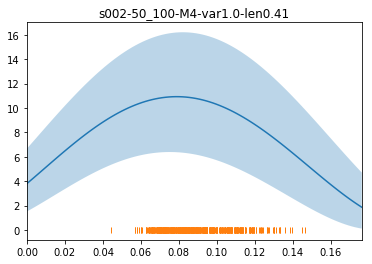

In [6]:
#画up事件强度的估值图
X_up = domain_grid(up_domain, N)
lambda_mean_up, lower_up, upper_up = model_up.predict_lambda_and_percentiles(X_up)
lower_up = lower_up.numpy().flatten()
upper_up = upper_up.numpy().flatten()

title_up = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(up_inducing_num) + '-var'+ str(up_variance) + '-len' + str(up_lengthscales)

plt.title(title_up)
plt.xlim(X_up.min(), X_up.max())
#plt.ylim(0, 15)
plt.plot(X_up, lambda_mean_up)
plt.fill_between(X_up.flatten(), lower_up, upper_up, alpha=0.3)
plt.plot(up_events, np.zeros_like(up_events), '|')
plt.show()

In [9]:
#kernel param for down
down_variance = 1.0
down_lengthscales = 0.5
down_inducing_num = 10

down_events,down_num_observations = build_data_for_down(object_user,object_data_str, object_data_end,filename)
down_events = np.array(down_events, float).reshape(-1, 1)

down_domain_max = max(down_events) + 0.1
down_domain = [0,down_domain_max]
down_domain = np.array(down_domain, float).reshape(1, 2)
print('down_domain is:', down_domain)

model_down = build_model(down_events, down_domain, down_num_observations, M=down_inducing_num, variance=down_variance, lengthscales = down_lengthscales)   #M是 inducing point的数量

def objective_closure_for_down():                           #目标函数
    return - model_down.elbo(down_events)

gpflow.optimizers.Scipy().minimize(objective_closure_for_down, model_down.trainable_variables)

down_domain is: [[0.     5.5143]]


      fun: 29.505665042921006
 hess_inv: <78x78 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02736603, -0.03165706,  0.01151717,  0.05717841, -0.00738905,
       -0.02957803,  0.19758   , -0.25778073,  0.02205833, -0.07370711,
        0.01344986,  0.09876737,  0.01684859,  0.01420029, -0.00143724,
        0.0596846 ,  0.00922468, -0.03602458,  0.03110128, -0.02476495,
        0.04695466, -0.03851702,  0.01951816, -0.00742402, -0.01641581,
       -0.01130484,  0.01214147,  0.03675757, -0.00293836,  0.01058952,
        0.01134909,  0.00702057,  0.00563464,  0.04930655,  0.0146754 ,
        0.00525783, -0.04034844, -0.04463839, -0.00119076, -0.03055311,
        0.01399679,  0.01801644,  0.0074422 ,  0.02930335, -0.26920654,
        0.02842629,  0.1322283 ,  0.07466237,  0.00205473,  0.01184132,
       -0.01369817,  0.00414045, -0.01659619, -0.01079906, -0.05176194,
       -0.09894121,  0.14931325, -0.31273994,  0.08516322, -0.07775168,
       -0.05811365, -0.06907788,  0.0

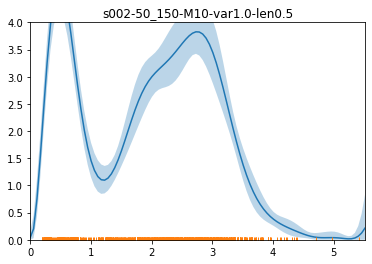

In [51]:
#画down事件强度的估值图
X_down = domain_grid(down_domain, N)
lambda_mean_down, lower_down, upper_down = model_down.predict_lambda_and_percentiles(X_down)
lower_down = lower_down.numpy().flatten()
upper_down = upper_down.numpy().flatten()

title_down = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(down_inducing_num) + '-var'+ str(down_variance) + '-len' + str(down_lengthscales)

plt.title(title_down)
plt.xlim(X_down.min(), X_down.max())
plt.ylim(0, 4)
plt.plot(X_down, lambda_mean_down)
plt.fill_between(X_down.flatten(), lower_down, upper_down, alpha=0.3)
plt.plot(down_events, np.zeros_like(down_events), '|')
plt.show()

In [52]:
#测试用户数据
w = 0.5

def positive_sample(user, test_data_str, test_data_end, filename):
    test_data_all = []
    for i in range (test_data_str, test_data_end):

        down_events,_ = build_data_for_down(user, i, i+1, filename)
        up_events,_ = build_data_for_up(user,i, i+1, filename)
        #print(i)
        
        down_events = np.array(down_events, float).reshape(-1, 1)
        up_events = np.array(up_events, float).reshape(-1, 1)
        #print(down_events)
        #print(up_events)

        test_data_likelihood_down = model_down.predict_y(down_events, down_domain, N)        
        test_data_likelihood_up = model_up.predict_y(up_events, up_domain, N)     
        
        test_data_likelihood = w*test_data_likelihood_down + (1-w)*test_data_likelihood_up
        test_data_all.append(test_data_likelihood)
        
    test_data_all_sort = sorted(test_data_all)
    
    mean = np.mean(test_data_all_sort)
    print('mean:',mean)
    
    mean = np.mean(test_data_all_sort[19:380])     #5%的outlier
    print('mean after outlier del:',mean)

    return mean,test_data_all
    
def negetive_sample(user, filename):
    down_events = make_estimate_data_for_down_all(fileName=filename, user=user)
    up_events = make_estimate_data_for_up_all(fileName=filename, user=user)
    #print(len(up_events))
    
    up_events = np.array(up_events, float).reshape(-1, 11)
    test_data_all = [] 
    
    
    for i in range (0, 2500):
        down_event = down_events[i]
        down_event = np.array(down_event, float).reshape(-1, 1)
        #print(down_event)
        
        up_event = up_events[i]
        up_event = np.array(up_event, float).reshape(-1, 1)
        #print(up_event)
        
        test_data_likelihood_down = model_down.predict_y(down_event, down_domain, N)        
        test_data_likelihood_up = model_up.predict_y(up_event, up_domain, N)
        
        test_data_likelihood = w*test_data_likelihood_down + (1-w)*test_data_likelihood_up
        test_data_all.append(test_data_likelihood)
        
    return  test_data_all


#样本的情况
def decision_fun(test_data_all, mean, threshold):
    
    distance = list( map(lambda x: abs(x - mean), test_data_all) )
    distance_array = np.array(distance)
    
    #距离大于threshold的样本个数
    out_num = np.sum((distance_array > threshold))
    return out_num


Start time is:  2020-08-16 20:54:38.046193
mean: 12.972465595647481
mean after outlier del: 13.188422078429358
i : 0
threshold is: 0.01
i : 1
threshold is: 0.21191919191919192
i : 2
threshold is: 0.41383838383838384
i : 3
threshold is: 0.6157575757575757
i : 4
threshold is: 0.8176767676767677
i : 5
threshold is: 1.0195959595959596
i : 6
threshold is: 1.2215151515151514
i : 7
threshold is: 1.4234343434343435
i : 8
threshold is: 1.6253535353535353
i : 9
threshold is: 1.8272727272727272
i : 10
threshold is: 2.029191919191919
i : 11
threshold is: 2.231111111111111
i : 12
threshold is: 2.4330303030303027
i : 13
threshold is: 2.6349494949494945
i : 14
threshold is: 2.8368686868686868
i : 15
threshold is: 3.0387878787878786
i : 16
threshold is: 3.2407070707070704
i : 17
threshold is: 3.4426262626262623
i : 18
threshold is: 3.644545454545454
i : 19
threshold is: 3.8464646464646464
i : 20
threshold is: 4.048383838383838
i : 21
threshold is: 4.25030303030303
i : 22
threshold is: 4.4522222222222

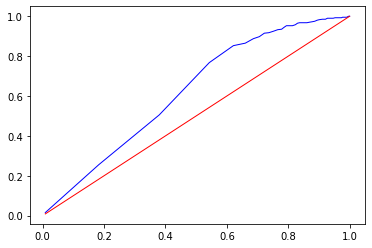

In [53]:
print('\nStart time is: ', datetime.datetime.today())

threshold_range = np.linspace(0.01,20,100)
FN = [0]*len(threshold_range)
TP = [0]*len(threshold_range)
FP = [0]*len(threshold_range)
TN = [0]*len(threshold_range)

false_alarm_rate = [0.0]*len(threshold_range)
miss_rate = [0.0]*len(threshold_range)
recall = [0.0]*len(threshold_range)
precision = [0.0]*len(threshold_range)

mean,test_data_all_positive = positive_sample(user=object_user, test_data_str=0, test_data_end=400, filename=filename)
test_data_all_negetive = negetive_sample(user=object_user, filename=filename)

#print('test_data_all_positive is:',np.array(test_data_all_positive))
#print('test_data_all_negetive is:',np.array(test_data_all_negetive))

for i,threshold in enumerate(threshold_range):
    print('i :',i)
    print('threshold is:',threshold)

    out_num = decision_fun(test_data_all=test_data_all_positive, mean=mean,threshold=threshold)   
    
    out_num_all = decision_fun(test_data_all=test_data_all_negetive, mean=mean, threshold=threshold)

    FN[i] = out_num
    TP[i] = 400 - out_num                         #400-out_num
    FP[i] = 2500 -  out_num_all                   #2500 - out_num_all
    TN[i] = out_num_all

    false_alarm_rate[i] = FP[i]/(FP[i]+TN[i])
    miss_rate[i] = FN[i]/(TP[i]+FN[i])
    recall[i] = TP[i]/(TP[i]+FN[i])
    precision[i] = TP[i]/(TP[i]+FP[i])    

print('FN is:', FN)
print('TP is:', TP)
print('FP is:', FP)
print('TN is:', TN)

print('false_alarm_rate is:',false_alarm_rate)
print('miss_rate is:',miss_rate)

#画false-alarm/hit rate ROC图
hit_rate = list( map(lambda x: 1 - x, miss_rate) )
print('hit_rate is:',hit_rate)
plt.plot(false_alarm_rate,hit_rate,color="blue",linewidth=1)
plt.plot(false_alarm_rate,false_alarm_rate,color="red",linewidth=1)

print('\n\nFinished.')
print('\nEnd time is: ', datetime.datetime.today())